### Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

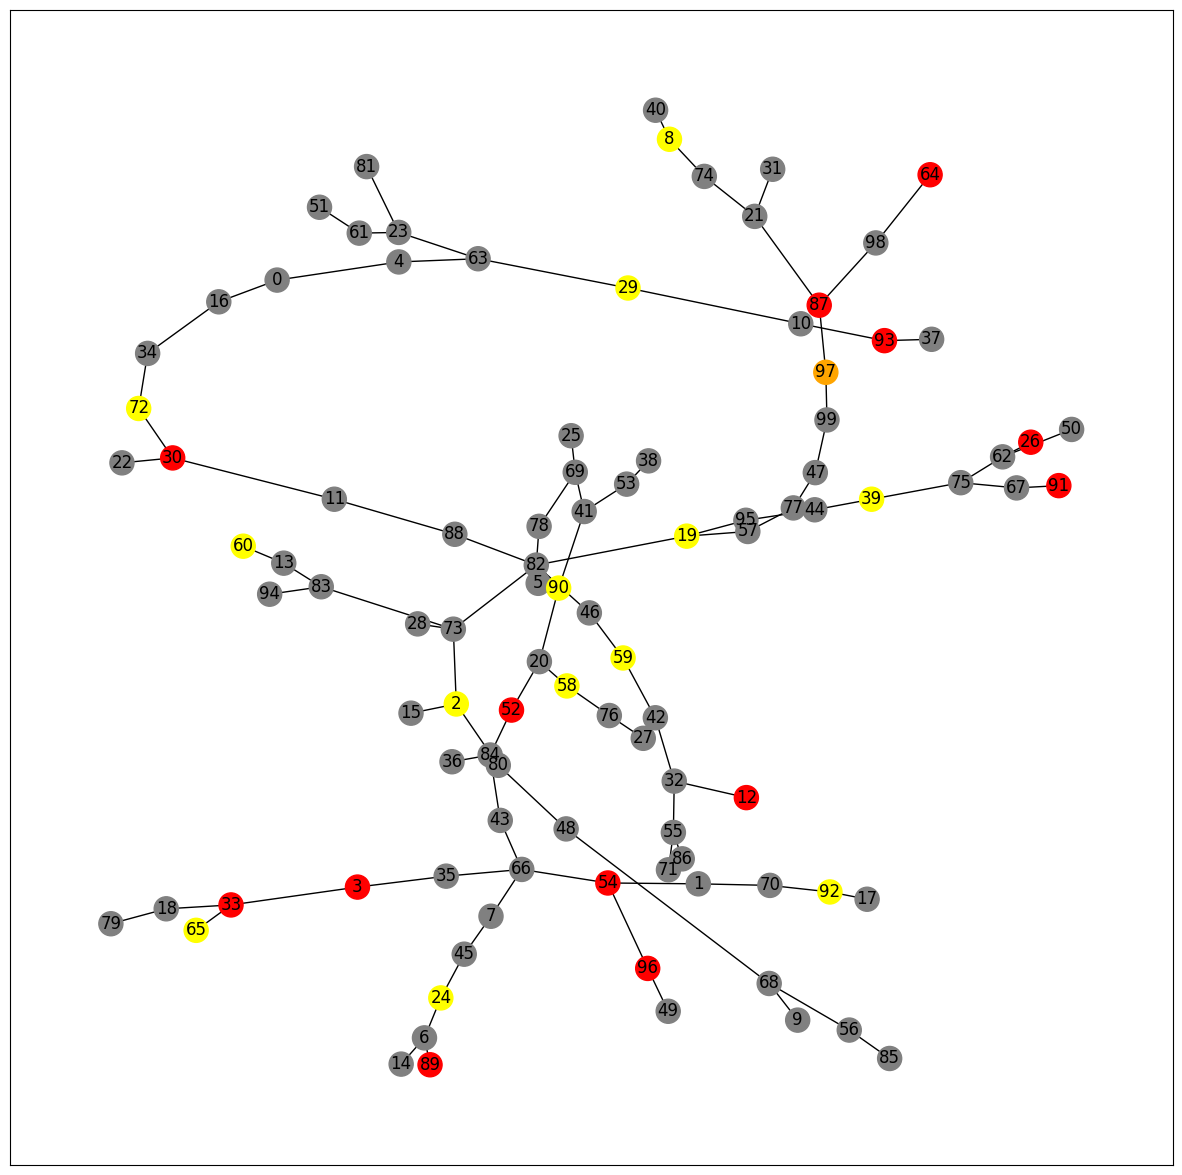

Is a tree: True
Number of edges:  99
Weight of the edges of the tree:  {(0, 4): 26.248809496813376, (0, 16): 89.5377015563835, (1, 70): 123.69316876852982, (1, 54): 110.16351483136329, (2, 15): 126.39620247459969, (2, 80): 183.92661580097646, (2, 73): 129.0620006043607, (3, 33): 38.01315561749642, (3, 35): 93.34345183246653, (4, 63): 68.26419266350405, (5, 90): 198.6454127333425, (6, 14): 136.4587849865299, (6, 89): 160.46183346827368, (6, 24): 160.5615146914104, (7, 45): 155.56670594957006, (7, 66): 125.02799686470227, (8, 40): 165.55965692160635, (8, 74): 116.0, (9, 68): 85.14693182963201, (10, 93): 83.67795408588812, (10, 29): 24.08318915758459, (11, 30): 23.600847442411894, (11, 88): 58.69412236331676, (12, 32): 35.805027579936315, (13, 60): 132.01893803541975, (13, 83): 171.42053552593984, (16, 34): 32.2490309931942, (17, 92): 166.97305171793442, (18, 79): 66.73080248281148, (18, 33): 94.79451460923254, (19, 95): 182.0164827701052, (19, 82): 59.033888572581766, (19, 57): 170.65755

In [1]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK WITH 3 FLOWS AND 150 AUTONOMY

N = 100 #number of nodes
K = 15 #number of flows
L = 150 #autonomy of the vehicles
edge_dim = 200 #dimension of the edges



T = uf.generate_random_network_tree(N, K, L, edge_dim)
flows = uf.get_random_flows(T, K)

# save the tree and the flows
uf.save_tree(T, flows, "tree_net/bigtree.gml")

uf.draw_tree(T, flows)

print(f'Is a tree: {nx.is_tree(T)}')
print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

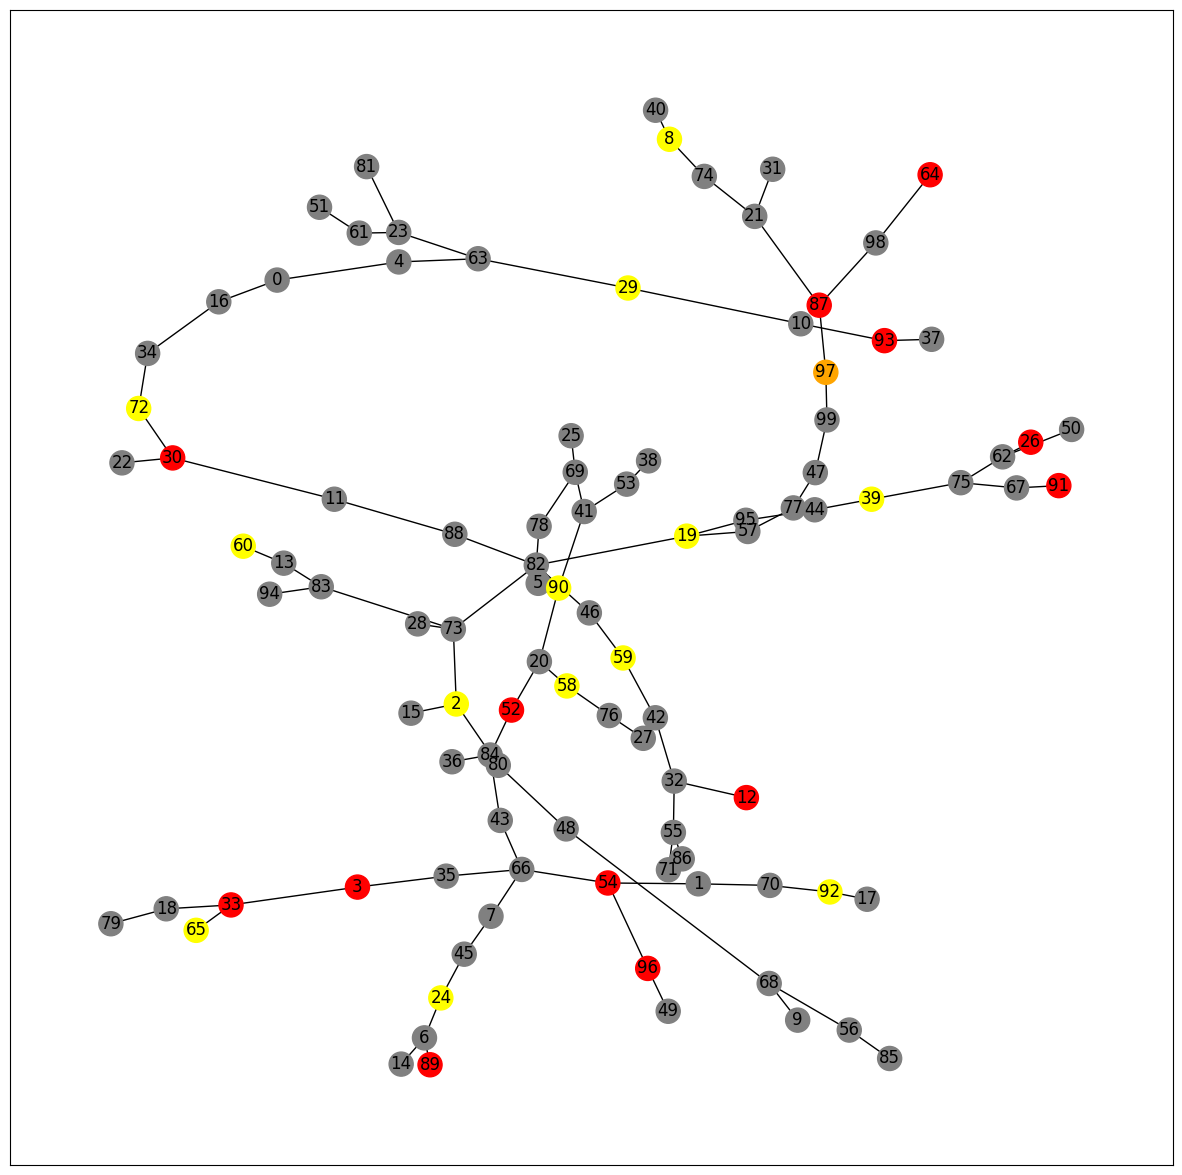

In [2]:
import networkx as nx
import utility_functions as uf

# READING THE TREE NETWORK FROM THE .gml FILE 
path_tree = "tree_net/bigtree.gml"
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")
uf.draw_tree(T, flows)

### 1_1 Prima greedy naive

1. Iniziamo con un insieme vuoto di stazioni di ricarica.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero, che è unico. Ogni veicolo (flusso) parte con autonomia L.
3. Mentre percorriamo il percorso, diminuiamo l'autonomia del veicolo della lunghezza dell'arco che si percorre.
4. Se l'autonommia non è sufficiente per percorrere il prossimo arco del percorso, quindi percorrendolo scenderebbe a zero o meno, posizioniamo una colonnina di ricarica sul nodo corrente.
5. Ripetiamo i passaggi 3-4 fino a quando tutti i veicoli hanno raggiunto le loro destinazioni.

Questa euristica cerca di minimizzare il numero di stazioni di ricarica posizionando ogni stazione il più lontano possibile lungo ogni percorso, dato che ogni veicolo parte con la carica completa e ogni stazione di ricarica ricarica completamente la batteria del veicolo.

Flows with their source and destination: [['96', '58'], ['54', '97'], ['30', '8'], ['87', '29'], ['91', '92'], ['26', '90'], ['89', '65'], ['33', '24'], ['3', '2'], ['52', '19'], ['91', '60'], ['12', '19'], ['97', '39'], ['64', '59'], ['93', '72']]
Paths (a path for each flow): [['96', '54', '66', '43', '84', '52', '20', '58'], ['54', '66', '43', '84', '52', '20', '90', '41', '69', '78', '82', '19', '57', '77', '47', '99', '97'], ['30', '11', '88', '82', '19', '57', '77', '47', '99', '97', '87', '21', '74', '8'], ['87', '97', '99', '47', '77', '57', '19', '82', '88', '11', '30', '72', '34', '16', '0', '4', '63', '29'], ['91', '67', '75', '39', '44', '95', '19', '82', '78', '69', '41', '90', '20', '52', '84', '43', '66', '54', '1', '70', '92'], ['26', '62', '75', '39', '44', '95', '19', '82', '78', '69', '41', '90'], ['89', '6', '24', '45', '7', '66', '35', '3', '33', '65'], ['33', '3', '35', '66', '7', '45', '24'], ['3', '35', '66', '43', '84', '52', '20', '90', '41', '69', '78', '82',

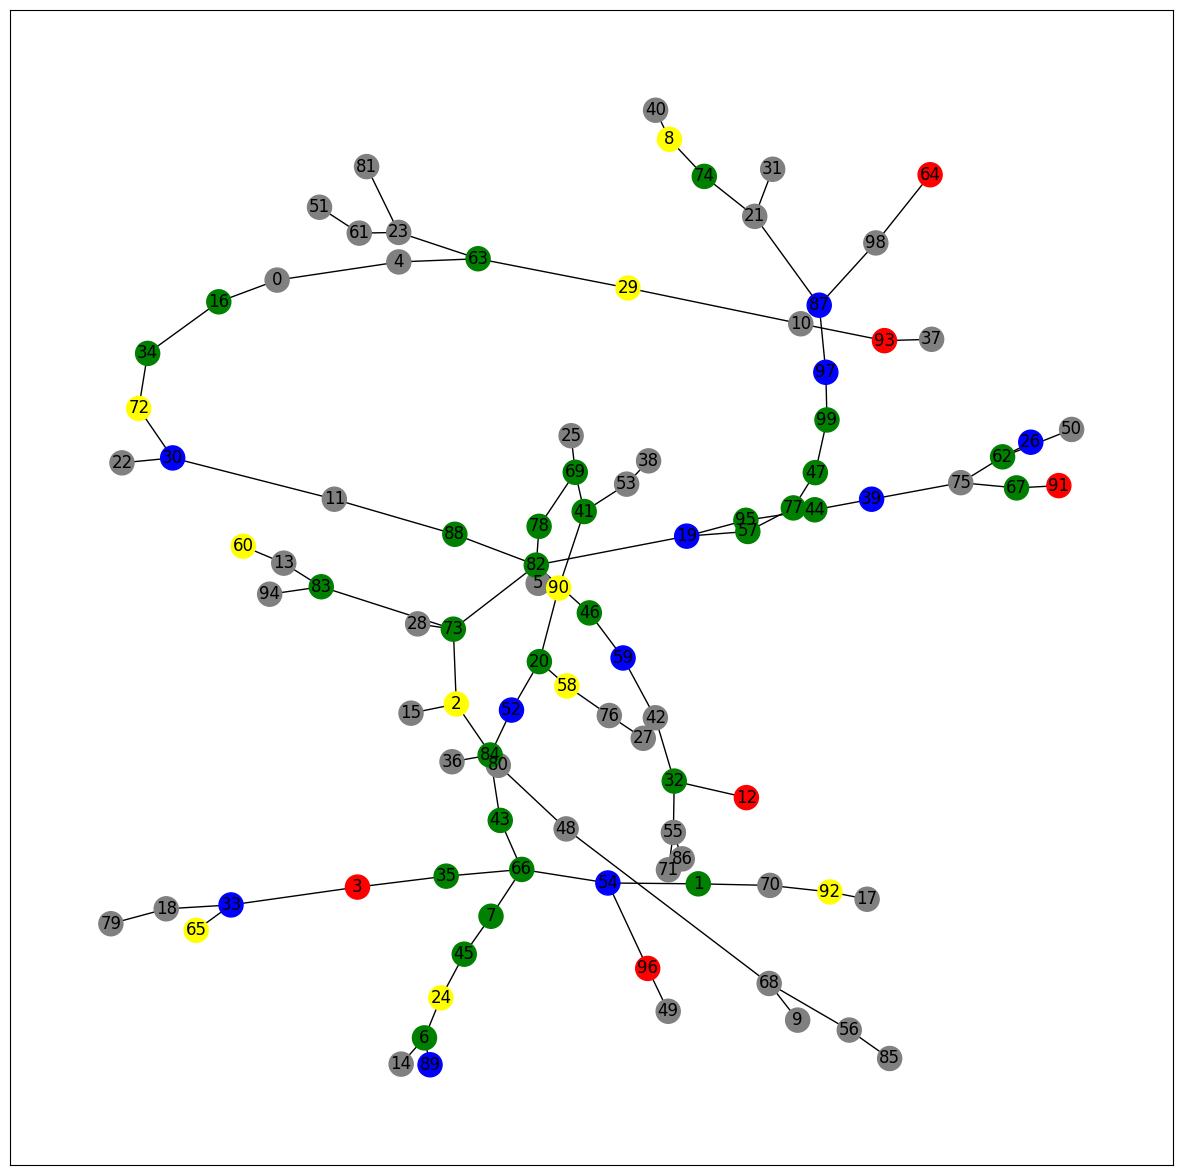

In [3]:
import networkx as nx
import utility_functions as uf

# file to save results
filename = '1_1'

# load all necessaries data
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_electric_charging(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                Tree.nodes[path[i]]['chrg_station'] = True
                charge = L
    return paths, charging_stations

paths, charging_stations = greedy_electric_charging(T, flows, L)

print("Flows with their source and destination:", flows)
print(f'Paths (a path for each flow): {paths}')
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Charging stations on nodes:", (charging_stations))

print(f"COST: (number of charging stations): {len(charging_stations)}")

uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))


### 1_2 Greedy con intersezione tra i flussi

1. Si percorre il flusso da sorgente a destinazione e poi da destinazione a sorgente utilizzando l'algoritmo greedy naive sopra descritto. In questo modo otteniamo, per ogni flow, due possibili modi ammissibili di posizionare le stazioni di ricarica.

2. Si generano tutte le possibili combinazioni di set di stazioni di ricarica per ogni flusso.

3. Per ogni possibile combinazione di posizionamenti di stazioni di ricarica, se ne calcola l'unione. L'unione rappresenta il totale delle colonnine e quindi il costo.

4. Si vuole minimizzare il costo, per cui si sceglie la combinazione di set che minimizza l'unione.

COST: (number of charging stations): 33


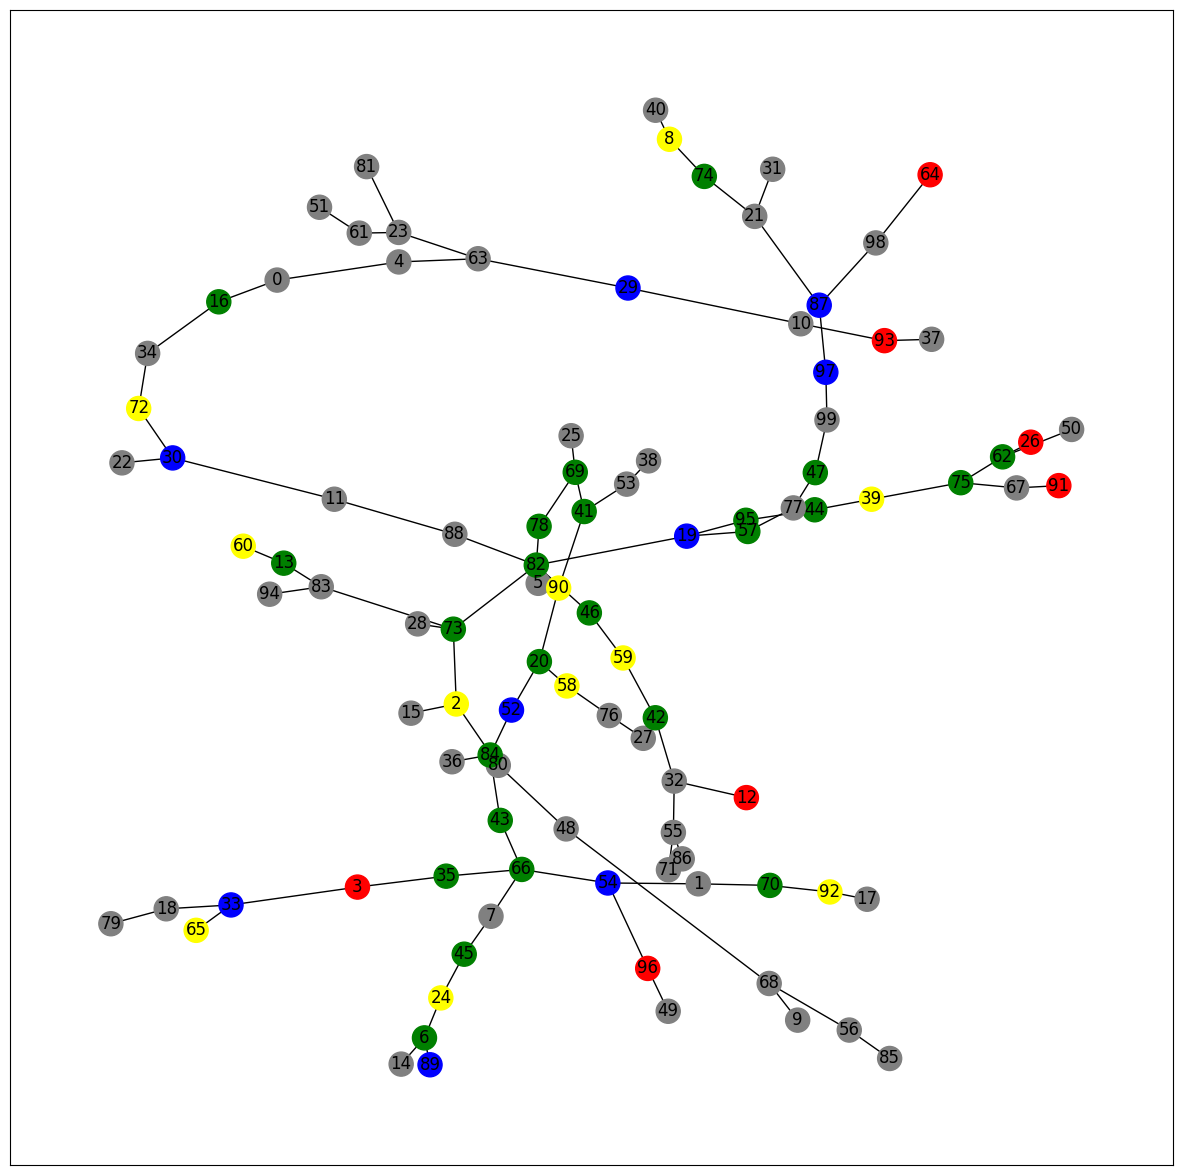

In [4]:
import itertools
import networkx as nx
import utility_functions as uf

filename = '1_2'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def possible_sets(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns two sets of charging stations for each flow, one for the forward path and one for the backward path.
    The dictionary has the following structure:
    {
        (flow1): [set11, set12],
        (flow2): [set21, set22],
        ...
    }
    '''
    charging_stations = {}
    paths_forward = uf.get_all_paths_of_all_flows(Tree, flows)
    paths_backward = [path[::-1] for path in paths_forward]

    for flow, path in zip(flows, paths_forward):
        charge = L
        charging_stations[tuple(flow)] = [set(), set()]  # Initialize with two empty sets
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations[tuple(flow)][0].add(path[i])  # Add to the first set
                charge = L
    
    for flow, path in zip(flows, paths_backward):
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations[tuple(flow)][1].add(path[i])  # Add to the second set
                charge = L

    return charging_stations

def generate_collections(flows):
    '''
    Generates all possible combinations of sets (cartesian product of the sets of charging stations for each flow)
    '''
    flow_sets = list(flows.values())
    combinations = list(itertools.product(*flow_sets))

    return combinations

def minimize_cost(possible_collections: list):
    '''
    Minimize the cost of the charging stations
    '''
    unions = [set.union(*collection) for collection in possible_collections]
    return min(unions, key=len)


flows_with_sets = possible_sets(T, flows, L)

possible_collections = generate_collections(flows_with_sets)

charging_stations = minimize_cost(possible_collections)
#print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")

uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)

uf.save_results(filename, list(charging_stations))




### 1_3_1 Greedy forward

Viene scelto il primo flusso da considerare in base alla lunghezza (prima il più lungo, ha con ogni probabilità più colonnine da posizionare).
Viene scelto il primo set per il primo flusso nella maniera forward. Per i successivi flussi, si utilizza sempre l'algoritmo greedy forward ma si tengono in considerazione le colonnine già posizionate per i flussi precedenti.

1. Si seleziona il flusso con path maggiore
2. Si inizializza un insieme di charging stations per tale flusso con l'algoritmo forward
3. Per i successivi flussi ordinati senso descrescente, si utilizza lo stesso algoritmo tenendo in considerazione le colonnine già posizionate per i flussi precedenti

Charging stations on nodes: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '6', '32', '99', '72', '73', '19', '88', '77', '82', '39', '74', '83', '66', '33', '43'}
COST: (number of charging stations): 42


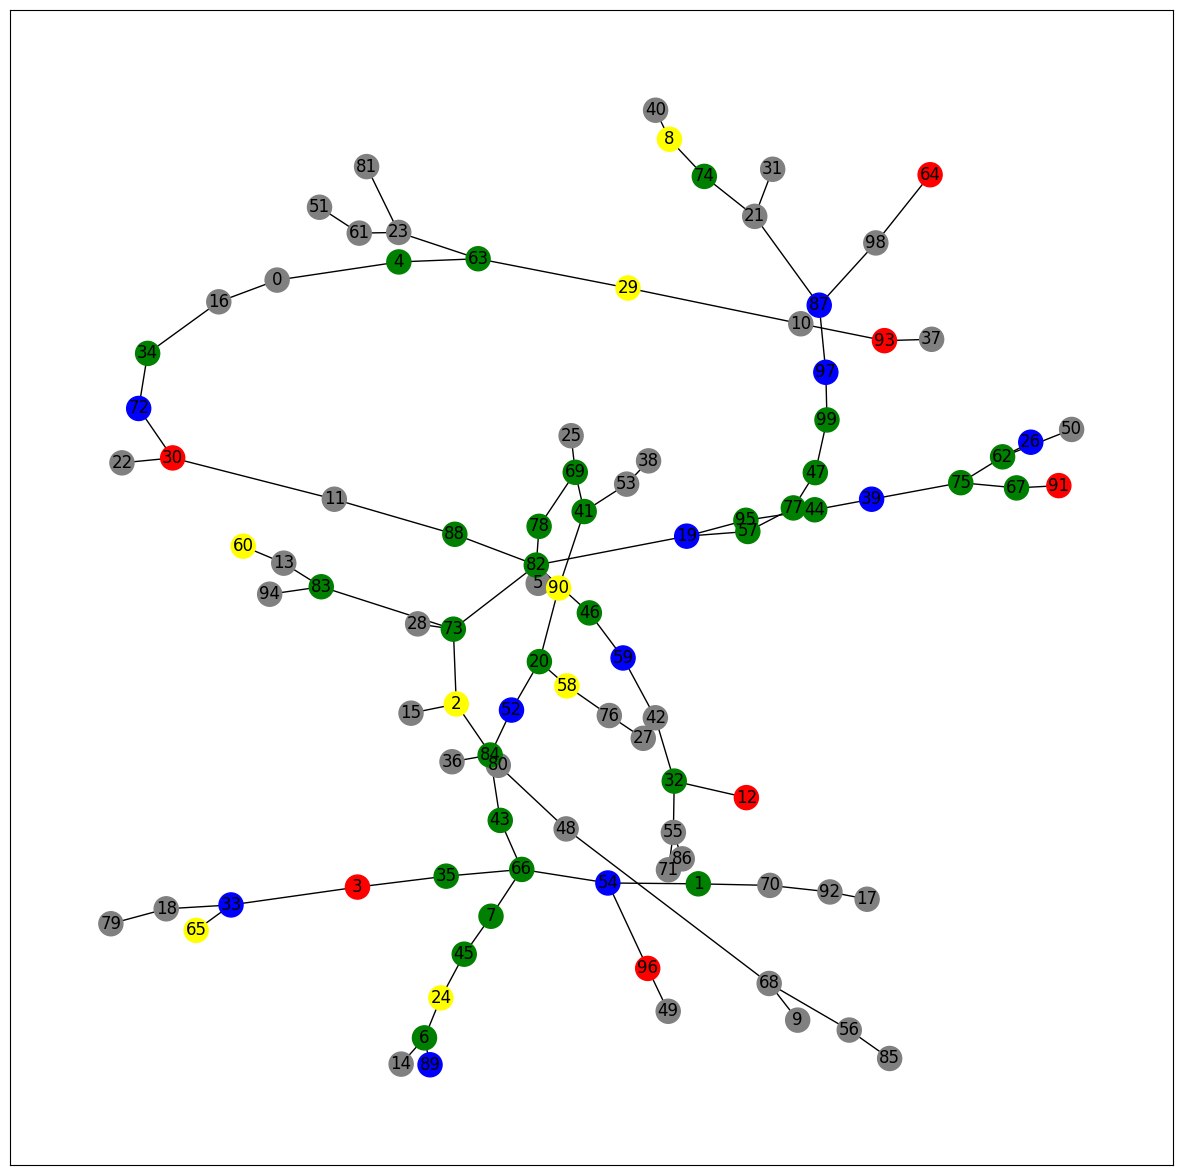

In [5]:
import networkx as nx
import utility_functions as uf

filename = '1_3_1'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def select_longest_flow(flows: list) -> tuple:
    '''
    Returns the flow with the longer path
    '''
    paths = uf.get_all_paths_of_all_flows(T, flows)
    max_path = max(paths, key=len)

    return [max_path[0], max_path[-1]]

def get_charging_stations_with_forward(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm
    '''
    flow = select_longest_flow(flows)
    flows.remove(flow)

    # Set the charging stations for the first flow
    charge = L
    path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
    charging_stations = set()
    for i in range(len(path) - 1):
        charge -= Tree.edges[(path[i], path[i+1])]['weight']
        if charge < 0:
            charging_stations.add(path[i])
            charge = L
    
    # Set the charging stations for the other flows based on the existing charging stations
    charge = L
    # Order flows decreasing order
    reverse_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))
    for flow in reverse_sorted_flows:
        charge = L
        path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
        for i in range(len(path) - 1):
            if path[i] in charging_stations:
                charge = L
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    
    return charging_stations

charging_stations = get_charging_stations_with_forward(T, flows, L)
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)

uf.save_results(filename, list(charging_stations))

### 1_3_2
Come la 1_3_1 ma con qualche modifica
- Primo flow selezionato in base alla lunghezza del path, infatti, viene scelto il flow in base al path maggiore
- flows ordinati in base alla lunghezza dei paths

Charging stations on nodes: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '6', '32', '99', '72', '73', '19', '77', '88', '82', '39', '74', '83', '66', '33', '43'}
COST: (number of charging stations): 42


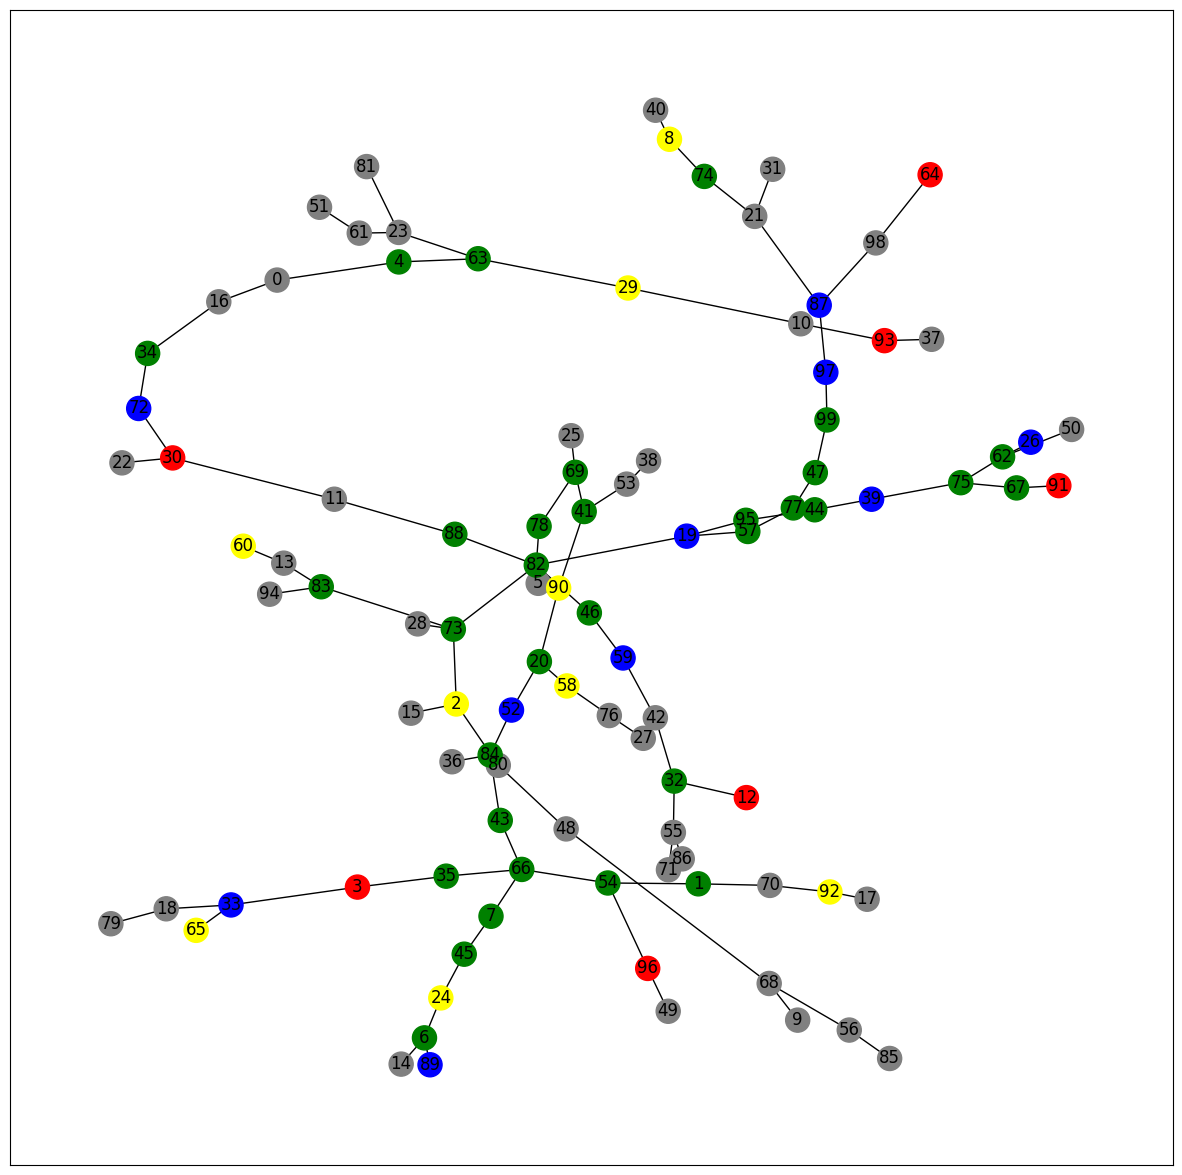

In [6]:
import networkx as nx
import utility_functions as uf

filename = '1_3_2'
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def select_the_longest_flows_path(flows: list) -> tuple:
    '''
    Returns the flow with the longer path
    '''
    _, paths_weights = uf.get_weights(T, flows)


    return flows[paths_weights.index(max(paths_weights))]

def get_charging_stations_with_forward(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm
    '''
    flow = select_the_longest_flows_path(flows)
    flows.remove(flow)

    # Set the charging stations for the first flow
    charge = L
    path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
    charging_stations = set()
    for i in range(len(path) - 1):
        charge -= Tree.edges[(path[i], path[i+1])]['weight']
        if charge < 0:
            charging_stations.add(path[i])
            charge = L
    
    # Set the charging stations for the other flows based on the existing charging stations
    charge = L
    # Order flows decreasing order
    reverse_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))
    for flow in reverse_sorted_flows:
        charge = L
        path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
        for i in range(len(path) - 1):
            if path[i] in charging_stations:
                charge = L
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    
    return charging_stations

charging_stations = get_charging_stations_with_forward(T, flows, L)
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))

### 1_3_3
Come la 1_3_1 ma con qualche modifia
- primo flow viene selezionato in base al suo peso
- flows ordinati in base ai pesi dei paths

Charging stations on nodes: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '32', '6', '99', '72', '73', '19', '77', '88', '82', '39', '74', '83', '66', '33', '43'}
COST: (number of charging stations): 42


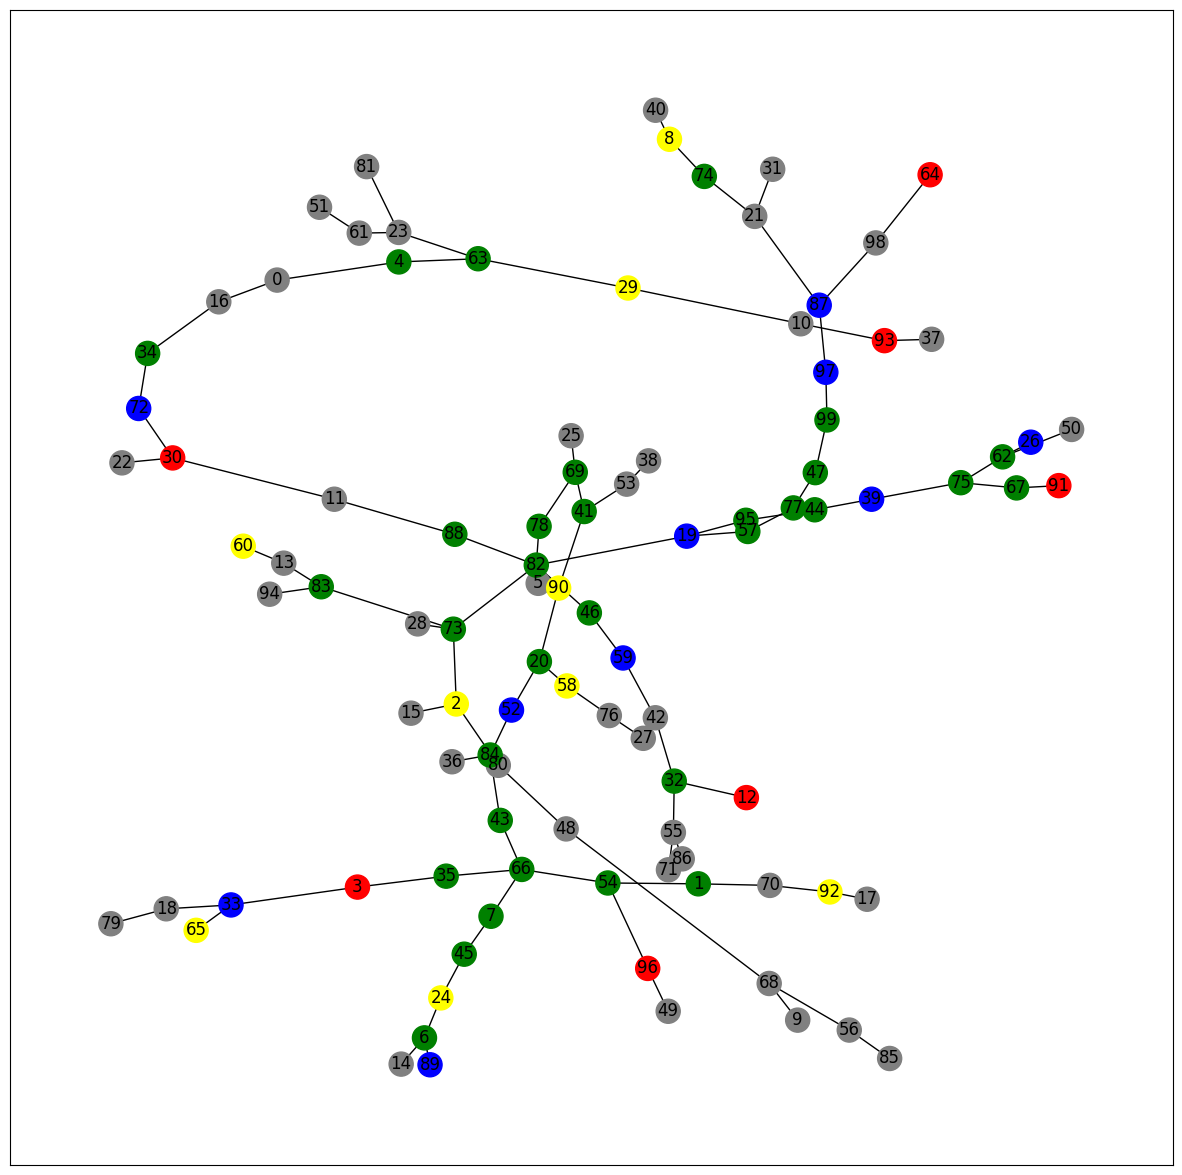

In [7]:
import networkx as nx
import utility_functions as uf

filename = '1_3_3'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def select_the_longest_flows_path(flows: list) -> tuple:
    '''
    Returns the flow with the longer path
    '''
    _, paths_weights = uf.get_weights(T, flows)


    return flows[paths_weights.index(max(paths_weights))]

def get_charging_stations_with_forward(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm
    '''
    flow = select_the_longest_flows_path(flows)
    flows.remove(flow)

    # Set the charging stations for the first flow
    charge = L
    path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
    charging_stations = set()
    for i in range(len(path) - 1):
        charge -= Tree.edges[(path[i], path[i+1])]['weight']
        if charge < 0:
            charging_stations.add(path[i])
            charge = L
    
    # Set the charging stations for the other flows based on the existing charging stations
    charge = L
    # Order flows decreasing order
    _, paths_weights = uf.get_weights(T, flows)
    reverse_sorted = sorted(zip(paths_weights, flows), reverse=True)
    reverse_sorted_flows = [t[1] for t in  reverse_sorted]
    for flow in reverse_sorted_flows:
        charge = L
        path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
        for i in range(len(path) - 1):
            if path[i] in charging_stations:
                charge = L
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    
    return charging_stations

charging_stations = get_charging_stations_with_forward(T, flows, L)
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))

### 1_4_1 Greedy in base ai nodi
#### Metodo naive
Calcolo i pesi dei nodi e posiziono la colonnina nel nodo col più alto.
1. Calcolo i pesi dei nodi e li ordino decrescente in base ai pesi
2. In ordine dal nodo più pesante al meno pesante, posiziono la colonnina nel nodo fino a quando la rete non è ammissibile

sorted_nodes_weights: [10, 10, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sorted_nodes_index: [82, 19, 66, 99, 97, 90, 78, 77, 69, 57, 52, 47, 41, 20, 95, 84, 44, 43, 39, 87, 75, 54, 35, 3, 91, 88, 73, 72, 67, 63, 59, 46, 45, 34, 33, 30, 29, 24, 16, 11, 7, 4, 0, 98, 96, 93, 92, 89, 83, 74, 70, 65, 64, 62, 60, 58, 42, 32, 26, 21, 13, 12, 10, 8, 6, 2, 1, 94, 86, 85, 81, 80, 79, 76, 71, 68, 61, 56, 55, 53, 51, 50, 49, 48, 40, 38, 37, 36, 31, 28, 27, 25, 23, 22, 18, 17, 15, 14, 9, 5]
Charging stations on nodes: {0, 3, 4, 6, 7, 8, 10, 11, 12, 13, 16, 19, 20, 21, 24, 26, 29, 30, 32, 33, 34, 35, 39, 41, 42, 43, 44, 45, 46, 47, 52, 54, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 74, 75, 77, 78, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 9

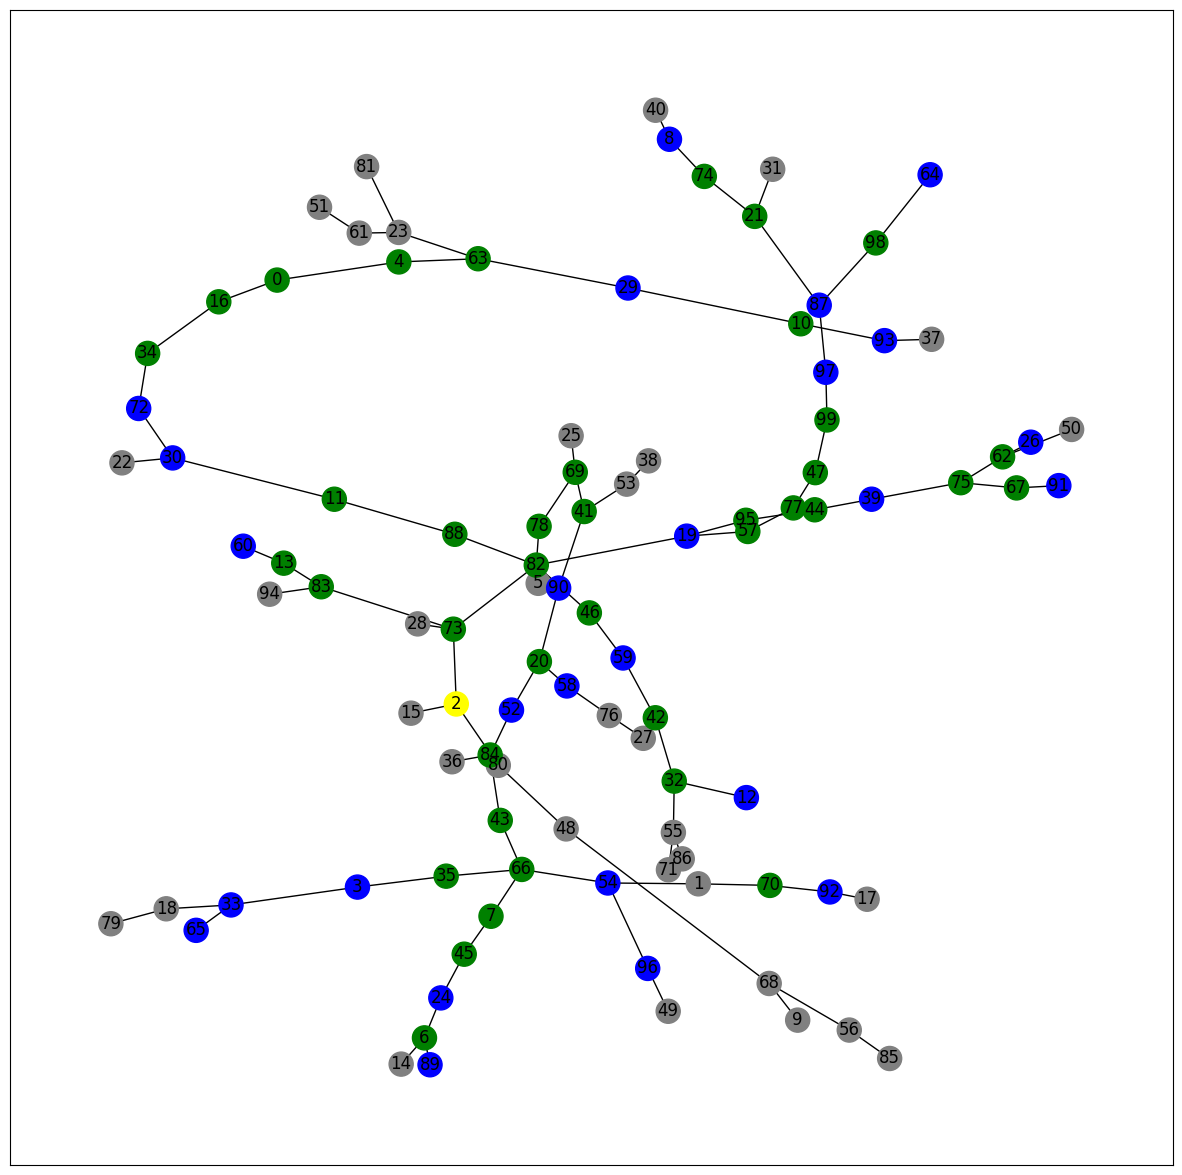

In [11]:
import networkx as nx
import utility_functions as uf

filename = '1_4_1'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def get_wight_of_neighbours_of_a_node(Tree: nx.Graph, node: str):
    '''
    Returns the weight of the edges connected to the node
    '''
    node = str(node)
    return [(int(ng_node), Tree.edges[(node, ng_node)]['weight']) for ng_node in list(Tree.neighbors(node))]

def get_nodes(Tree: nx.Graph, flows: list, L: int):
    '''
    Return the charging stations set for the nodes of the tree
    '''
    N = Tree.graph['N']
    nodes_index = list(range(N))
    charging_stations = set()
    Copy_tree = Tree.copy()
    # print("Flows with their source and destination:", flows)

    # get weight of the nodes
    nodes_weights, _ = uf.get_weights(T, flows)
    sorted_tuples = sorted(zip(nodes_weights, nodes_index), reverse=True)
    sorted_nodes_weights, sorted_nodes_index = zip(*sorted_tuples)
    sorted_nodes_weights = list(sorted_nodes_weights)
    sorted_nodes_index = list(sorted_nodes_index)

    
    while not uf.is_admissible(Copy_tree, flows, L):
        Copy_tree = Tree.copy()
        node = sorted_nodes_index[0]
        _ = sorted_nodes_weights[0]
        sorted_nodes_weights.pop(0)
        sorted_nodes_index.pop(0)

        charging_stations.add(node)
        uf.set_chrg_stations(Copy_tree, list(charging_stations))

    return charging_stations

nodes_index = list(range(N))
nodes_weights, _ = uf.get_weights(T, flows)
sorted_tuples = sorted(zip(nodes_weights, nodes_index), reverse=True)
sorted_nodes_weights, sorted_nodes_index = zip(*sorted_tuples)
sorted_nodes_weights = list(sorted_nodes_weights)
sorted_nodes_index = list(sorted_nodes_index)
print(f'sorted_nodes_weights: {sorted_nodes_weights}')
print(f'sorted_nodes_index: {sorted_nodes_index}')
    

charging_stations = get_nodes(T, flows, L)
uf.set_chrg_stations(T, list(charging_stations))
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
uf.save_results(filename, list(charging_stations))
uf.draw_tree(T, flows)


#### 1_4_2 Metodo meno naive
1. Calcolo i pesi dei nodi e li ordino decrescente in base ai pesi
2. In ordine dal nodo più pesante al meno pesante, posiziono la colonnina nel nodo.
3. Per ogni colonnina posizionata, calcolo la weight dei nodi vicini e se è minore di L tali nodi li mando in fondo alla lista dei nodi ordinati

sorted_nodes_weights: [10, 10, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sorted_nodes_index: [82, 19, 66, 99, 97, 90, 78, 77, 69, 57, 52, 47, 41, 20, 95, 84, 44, 43, 39, 87, 75, 54, 35, 3, 91, 88, 73, 72, 67, 63, 59, 46, 45, 34, 33, 30, 29, 24, 16, 11, 7, 4, 0, 98, 96, 93, 92, 89, 83, 74, 70, 65, 64, 62, 60, 58, 42, 32, 26, 21, 13, 12, 10, 8, 6, 2, 1, 94, 86, 85, 81, 80, 79, 76, 71, 68, 61, 56, 55, 53, 51, 50, 49, 48, 40, 38, 37, 36, 31, 28, 27, 25, 23, 22, 18, 17, 15, 14, 9, 5]
Cost (number of charging stations): 91


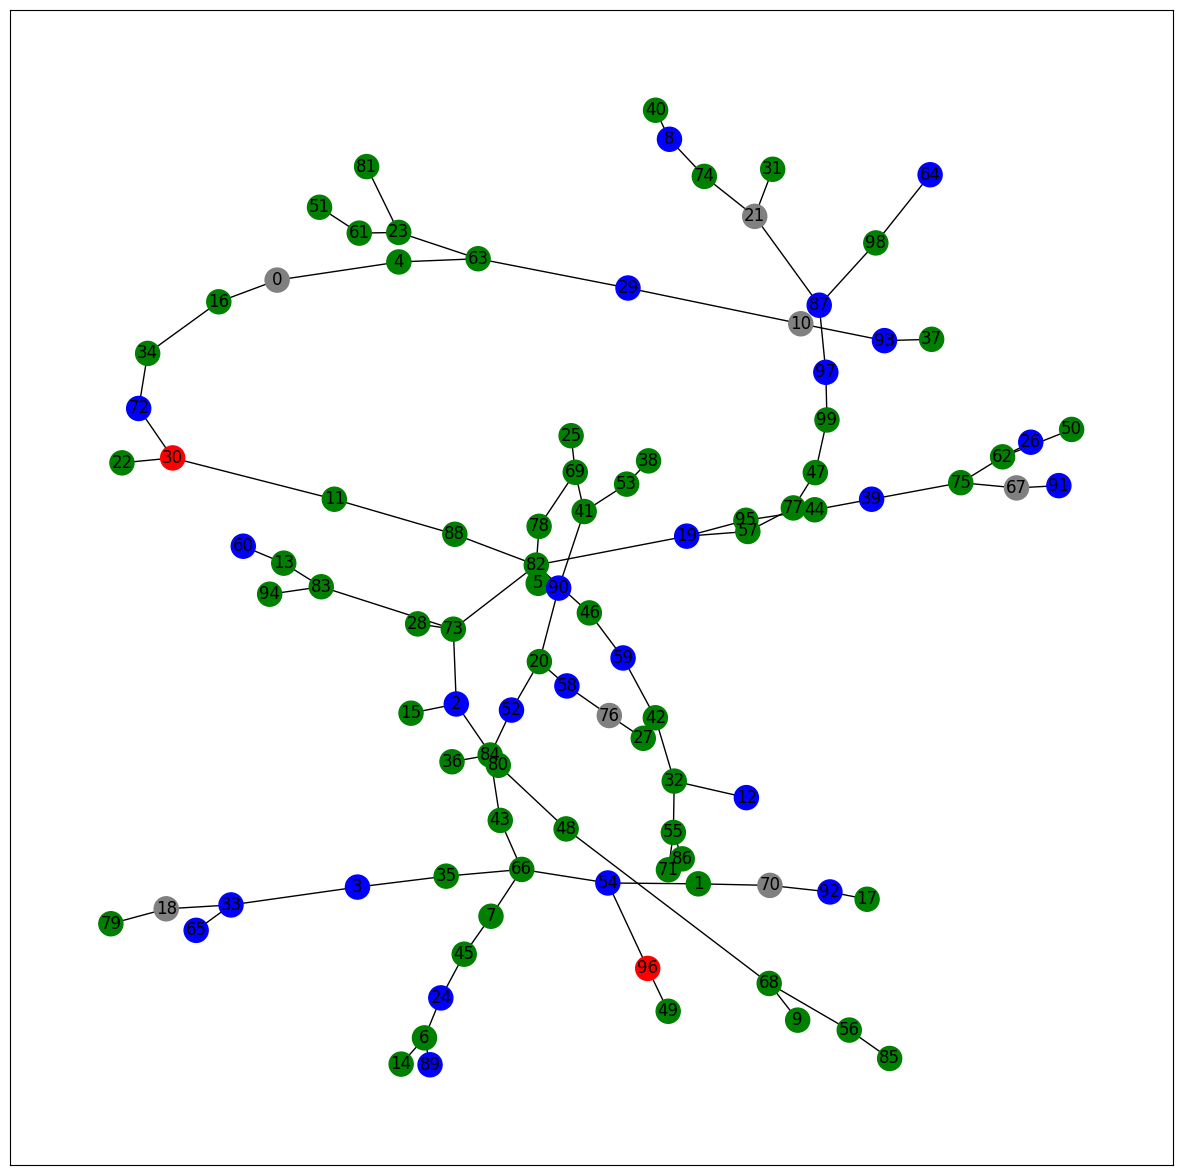

In [21]:
import networkx as nx
import utility_functions as uf

filename = '1_4_2'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def get_wight_of_neighbours_of_a_node(Tree: nx.Graph, node: str):
    '''
    Returns the weight of the edges connected to the node
    '''
    node = str(node)
    return [(int(ng_node), Tree.edges[(node, ng_node)]['weight']) for ng_node in list(Tree.neighbors(node))]

def get_nodes(Tree: nx.Graph, flows: list, L: int):
    '''
    Return the charging stations set for the nodes of the tree
    '''
    N = Tree.graph['N']
    nodes_index = list(range(N))
    charging_stations = set()
    Copy_tree = Tree.copy()
    # print("Flows with their source and destination:", flows)

    # get weight of the nodes
    nodes_weights, _ = uf.get_weights(T, flows)
    sorted_tuples = sorted(zip(nodes_weights, nodes_index), reverse=True)
    sorted_nodes_weights, sorted_nodes_index = zip(*sorted_tuples)
    sorted_nodes_weights = list(sorted_nodes_weights)
    sorted_nodes_index = list(sorted_nodes_index)

    
    while not uf.is_admissible(Copy_tree, flows, L):
        Copy_tree = Tree.copy()
        node = sorted_nodes_index[0]
        _ = sorted_nodes_weights[0]
        sorted_nodes_weights.pop(0)
        sorted_nodes_index.pop(0)

        charging_stations.add(node)

        #print(f'wights: {node}, {get_wight_of_neighbours_of_a_node(Copy_tree, node)}')
        tuple_of_neighbours = get_wight_of_neighbours_of_a_node(Copy_tree, node)
        for ng_node, edge_weight in tuple_of_neighbours:
            if edge_weight < L and ng_node not in charging_stations and ng_node in sorted_nodes_index:
                
                # get index of the weight of the node in the sorted list
                index = sorted_nodes_index.index(ng_node)

                # swap the node wight to the end of the list
                node_wight = sorted_nodes_weights.pop(index)
                #print(f'node_wight: {node_wight}')
                sorted_nodes_weights.append(node_wight)

                # swap the node index to the end of the list
                sorted_nodes_index.remove(ng_node)
                sorted_nodes_index.append(ng_node)

        

        
        uf.set_chrg_stations(Copy_tree, list(charging_stations))

    return charging_stations

nodes_index = list(range(N))
nodes_weights, _ = uf.get_weights(T, flows)
sorted_tuples = sorted(zip(nodes_weights, nodes_index), reverse=True)
sorted_nodes_weights, sorted_nodes_index = zip(*sorted_tuples)
sorted_nodes_weights = list(sorted_nodes_weights)
sorted_nodes_index = list(sorted_nodes_index)
print(f'sorted_nodes_weights: {sorted_nodes_weights}')
print(f'sorted_nodes_index: {sorted_nodes_index}')
    

charging_stations = get_nodes(T, flows, L)
print(f'Cost (number of charging stations): {len(charging_stations)}')
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))


### Ricerca locale
L'algoritmo di ricerca locale deve muoversi nello spazio delle soluzioni, partendo da una soluzione iniziale e cercando di migliorarla.

Questo particolare algoritmo assume come soluzione quella delle sezioni degli algoritmi greedy.

1. Carico il tree salvato.
2. Inizializzare una soluzione con colonnine di ricarica come la soluzione dal file json.
3. Per ogni nodo della soluzione, provare a rimuovere la colonnina di ricarica e verificare se tutti i veicoli possono ancora raggiungere le loro destinazioni.
4. Ripetere il passaggio 3 fino a quando non si riesce più a migliorare.

Charging stations on nodes before purify: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99]
COST: (number of charging stations before the purify): 91
Charging stations on nodes after purify: ['1', '6', '7', '16', '19', '20', '26', '32', '35', '39', '41', '44', '45', '46', '47', '52', '54', '57', '59', '62', '63', '66', '69', '72', '74', '75', '77', '82', '83', '84', '87', '88', '89', '91', '95', '97', '99']
COST: (number of charging stations after the purify): 37
charging_stations: ['1', '6', '7', '16', '19', '20', '26', '32', '35', '39', '41', '44', '45', '46', '47', '52', '54', '57', '59', '62', '63', '66', '69', '72', '74', '75', '77', '82', '83', '84', '87', '88', '89', '91', '95',

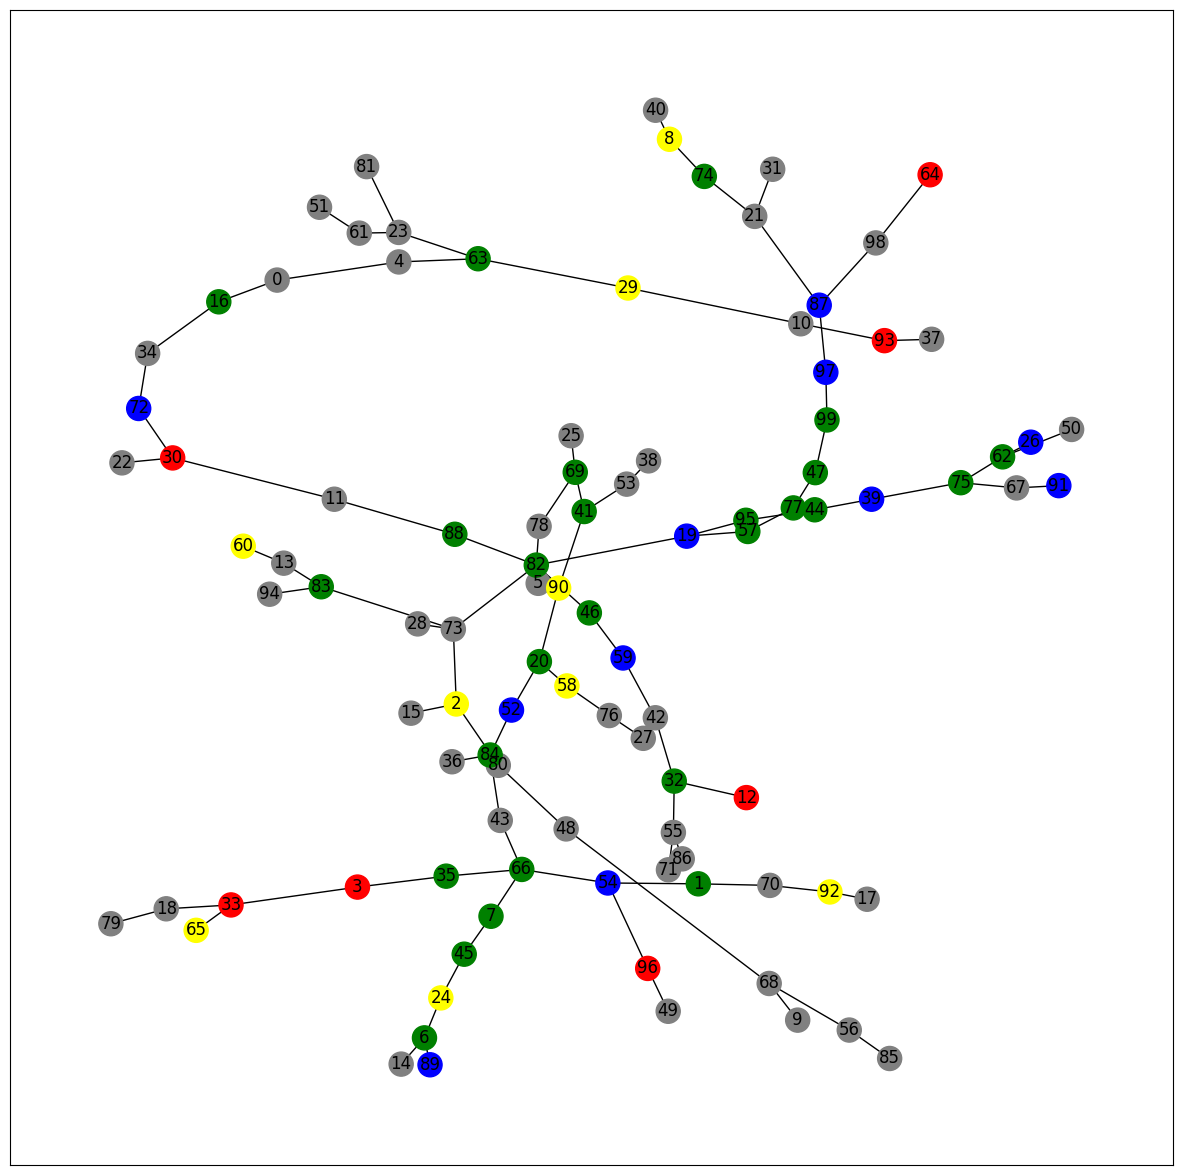

In [22]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

# provo a spegnere le stazioni di ricarica e testare se i veicoli riescono a raggiungere la destinazione
def purify_charging_stations(Tree: nx.Graph, charging_stations: set, flows: list):
    charging_stations = [str(element) for element in charging_stations]
    L = Tree.graph['L']
    Copy_tree = Tree.copy()
    uf.set_chrg_stations(Copy_tree, list(charging_stations))
    real_charging_stations = set()
    real_charging_stations = charging_stations.copy()
    for node in charging_stations:
        Copy_tree.nodes[node]['chrg_station'] = False
        if not uf.is_admissible(Copy_tree, flows, L):
            Copy_tree.nodes[node]['chrg_station'] = True
        else:
            real_charging_stations.remove(node)
    
    return real_charging_stations


#charging_stations = get_charging_stations_with_forward(T, flows)
charging_stations = uf.load_results('1_4_2')
print("Charging stations on nodes before purify:", (charging_stations))
print(f"COST: (number of charging stations before the purify): {len(charging_stations)}")

# now I try to remove the charging stations that are not necessary
charging_stations = purify_charging_stations(T, charging_stations, flows)
print("Charging stations on nodes after purify:", (charging_stations))
print(f"COST: (number of charging stations after the purify): {len(charging_stations)}")
print(f'charging_stations: {charging_stations}')
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)

### Altra ricerca locale
Implemento l'algoritmo di prima ma con la feature di cercare il minimo costo possibile e cioè se il costo risulta lo stesso valore per almeno depth volte consecutive

Initial solution: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '6', '32', '99', '72', '73', '19', '88', '77', '82', '39', '74', '83', '66', '33', '43'} and cost: 42


Initial solution: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '6', '32', '99', '72', '73', '19', '88', '77', '82', '39', '74', '83', '66', '33', '43'} and cost: 42
Initial solution: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '6', '32', '99', '72', '73', '19', '88', '77', '82', '39', '74', '83', '66', '33', '43'} and cost: 42
Initial solution: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89', '63', '97', '7', '6', '32', '99', '72', '73', '19', '88', '77', '82', '39', '74', '83', '66', '33', '43'} and cost: 42
Initial solution: {'95', '87', '67', '78', '47', '41', '26', '34', '75', '46', '54', '35', '62', '52', '69', '45', '20', '44', '59', '57', '84', '4', '1', '89',

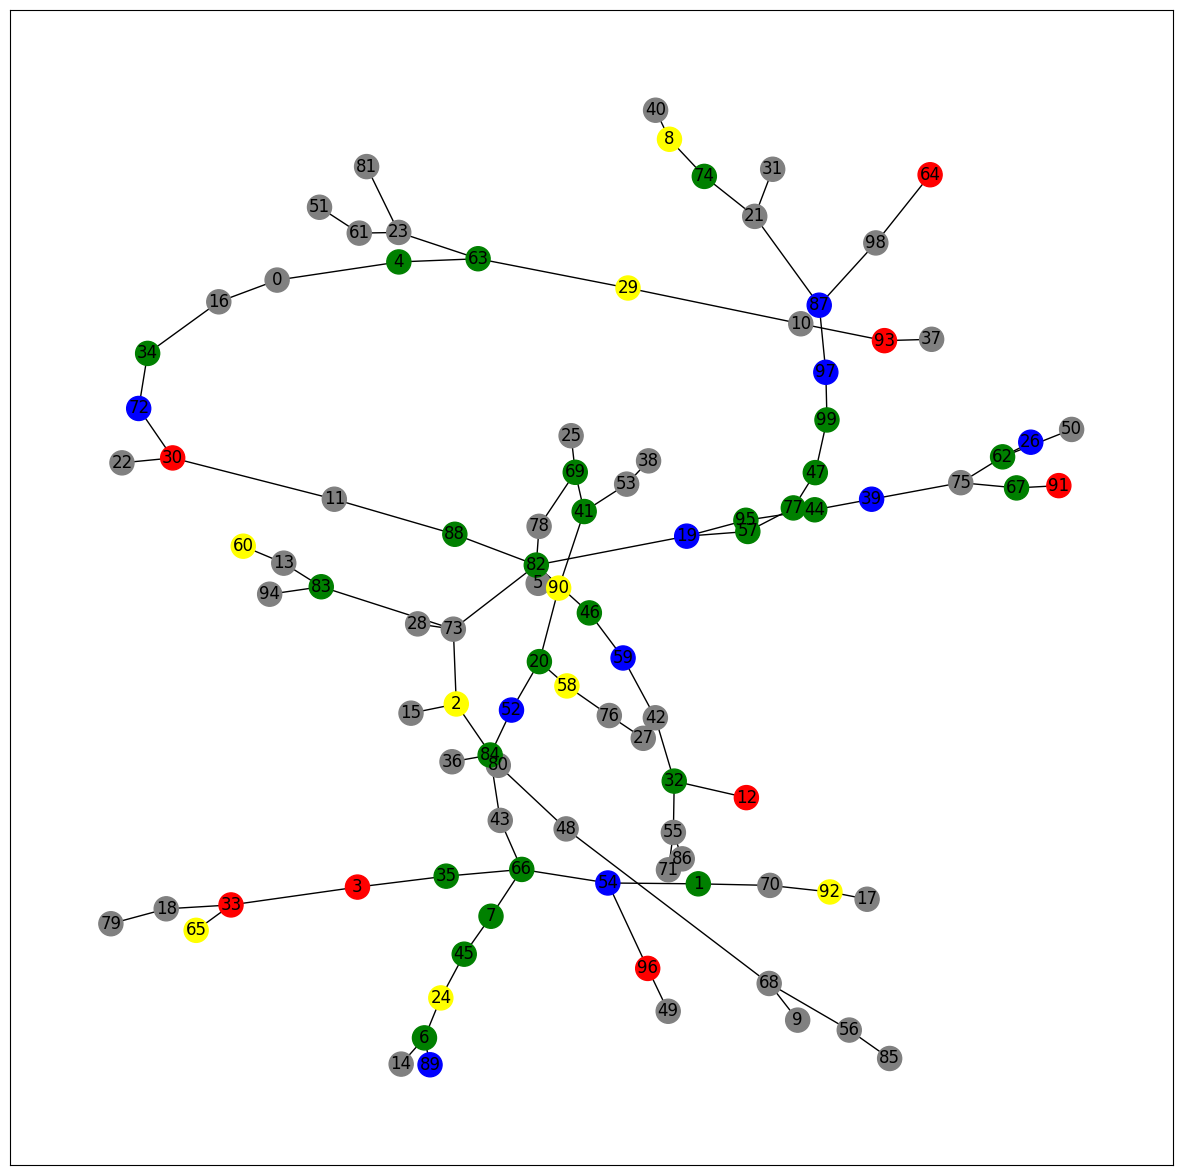

In [11]:
import networkx as nx
import utility_functions as uf

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")
depth = 10 # number of consecutive iterations that cost must be the same value in the local search


def local_search(G, flows, L):
    charging_stations = set(uf.load_results('1_3_1'))
    uf.set_chrg_stations(G, list(charging_stations))
    cost = len(charging_stations)  # initial cost

    print(f"Initial solution: {charging_stations} and cost: {cost}")

    improved = True
    while improved:
        improved = False
        for node in list(charging_stations):
            charging_stations.remove(node)
            G.nodes[node]['chrg_station'] = False
            if uf.is_admissible(G, flows, L):
                cost -= 1
                improved = True
            else:
                charging_stations.add(node)
                G.nodes[node]['chrg_station'] = True

    return charging_stations, cost

def search(G, flows, L, depth):
    charging_stations, cost = local_search(G, flows, L)
    flag_cost = cost
    cont = 0

    while cont < depth:
        charging_stations, cost = local_search(G, flows, L)
        if cost == flag_cost:
            cont += 1
        else:
            cont = 0
        flag_cost = cost

    return charging_stations, cost

charging_stations, cost = search(T, flows, L, depth)

print(f"Charging stations: {charging_stations}")
print(f"Cost: {cost}")
uf.draw_tree(T, flows)
